In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering and the k-means algorithm


**Contents**

- [The k-means algorithm](#1.-The-k-means-algorithm)
- [How does the k-means algorithm work?](#2.-How-does-the-k-means-algorithm-work?)
- [Inertia and other cluster metrics](#3.-Inertia-and-other-cluster-metrics)
- [Finding the optimal number of clusters: the elbow method](#4.-Finding-the-optimal-number-of-clusters:-the-elbow-method)

## 1. The k-means algorithm

Consider the following unlabeled toy dataset

In [2]:
from sklearn.datasets import make_blobs

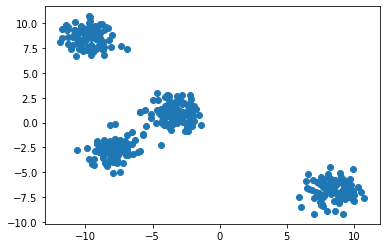

In [23]:
X,y = make_blobs(n_samples=400,
                 centers = 4,
                 cluster_std=1) 
plt.scatter(X[:,0],X[:,1])

We can clearly see four blobs (clusters). The k-means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly.

Let us train a $k$-means clusterer on this toy dataset.
We need to specify the number of clusters $k$ that the algorithm must find. 
In this example, it is pretty obvious from looking at the data that $k$ should be set to 4. 
In general, choosing $k$ is not that easy.
We will discuss this shortly.

In [24]:
from sklearn.cluster import KMeans
# choose number of clusters
k = 4 
# instantiate k-means clusterer
kmeans = KMeans(n_clusters = k)
# train the cluster
kmeans.fit(X)

KMeans(n_clusters=4)

The $k$-means method will try to find each blob's center and assign each point to the closest blob.

In [25]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
centers

array([[ 8.40811306, -6.7823022 ],
       [-3.40188422,  0.97477501],
       [-9.75569229,  8.60792471],
       [-7.97974268, -2.78025335]])

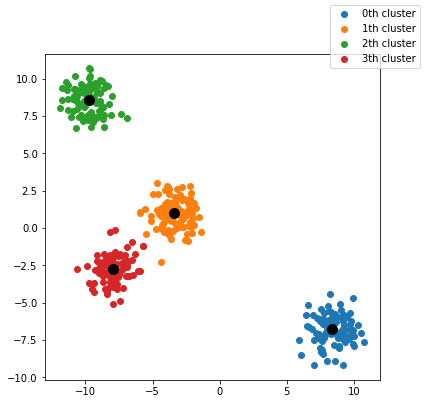

In [26]:
# plot clusters
fig, ax = plt.subplots(figsize=(6,6))
for i in range(k):
    # plot ith cluster
    ax.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    ax.scatter(centers[i,0],centers[i,1], c='k', s=100)
fig.legend()

If we plot the classification regions of a k-means clusterer, we'll get what is called a **Voronoi tesselation**

In [27]:
def plot_decision_regions(model,X):
    
    # extract feature names
    try:
        feature_names = X.columns
    except:
        feature_names = ['feature #1','feature #2']
    
    # put data into numpy arrays
    try:
        X = np.array(X)
    except:
        print('something went wrong...')
        
    # create a mesh grid
    h = .01
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    #  assign grid points to clusters
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plot Voronoi regions
    plt.contourf(Z, extent=(x_min,x_max,y_min,y_max),cmap='Pastel2_r')
    plt.contour(Z, extent=(x_min,x_max,y_min,y_max),linewidths=1,colors='k')
    
    # plot data
    plt.scatter(X[:,0],X[:,1],color='k',s=15)

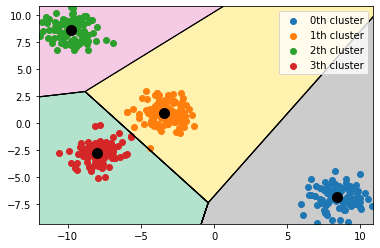

In [28]:
plot_decision_regions(kmeans,X)

for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()

Now that we have a trained k-means clusterer, we can assign new points to the cluster whose center is closest

In [29]:
new_points = np.array([
    [-2,-5],
    [4,8],
    [8,-10],
    [12,0]
])

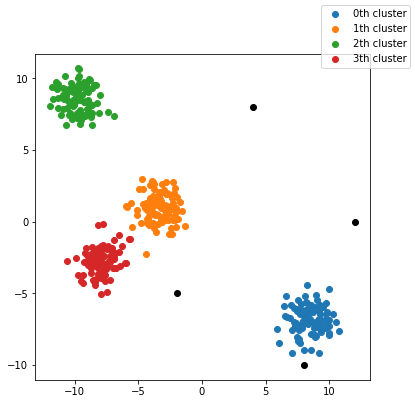

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(k):
    # plot ith cluster
    ax.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    #ax.scatter(centers[i,0],centers[i,1], c='k', s=100)
fig.legend()
ax.scatter(new_points[:,0],new_points[:,1],c='k')

In [31]:
kmeans.predict(new_points)

array([1, 1, 0, 0])

## 2. How does the k-means algorithm work?

- Initialize the $k$ cluster centers at random: $k$ distinct points are chosen randomly from the data set
- Repeat until the centers stop moving:
    - Assign each point to the closest cluster center
    - Update the centers to be the mean of the points that are assigned to them.

![kmeans](kmeans.png)

## 3. Inertia and other cluster metrics

### Inertia

The $k$-means algorithm aims to choose clusters that minimise the **inertia** (aka, the within-cluster sum-of-squares).
The **inertia** is the mean squared distance between each dataset point and its closest cluster mean.
If we denote by $C_i$ the $i$th cluster and by $m_i$ the center (the mean) of $C_i$, the inertia is given by
$$
\mbox{inertia} = \frac{1}{m}\sum_{i=1}^k \sum_{x\in C_i} \|x-m_i\|_2^2,
$$
where $m$ is the size of the dataset.

We can access the clusterer's inertia via the `inertia_` method

In [32]:
kmeans.inertia_

724.1039652045415

Inertia can be recognized as a measure of how internally coherent clusters are. Lower inertia values are better and zero is optimal.

### Silhouette score

Another cluser metric is the silhouette score.
The **silhouette score** is the mean silhouette coefficient over all the dataset points.
For a datapont $x_i$ in cluster $C_i$, its **silhouette coefficient** is computed as follows.
First, we need to compute its mean distance to the other points in the same cluster:

$$
a = \frac{1}{\mbox{size cluster $C_i$ - 1}}\sum_{x_j\in C_i}\mathrm{distance}\,(x_i,x_j).
$$

We divide by $\mbox{size cluster $C_i$ - 1}$ because we do not include the distance from $x_i$ to itself.
Secondly, we compute the mean distance to the points of the next closest cluster:

$$
b = \min_{C_k\neq C_i}\left\{ \frac{1}{\mbox{size cluster $C_k$}}\sum_{x_j\in C_k}\mathrm{distance}\,(x_i,x_j)\right\}.
$$

The **silhouette coefficient** of $x_i$ is

$$
s = \left\{
\begin{array}{ll}
\dfrac{b-a}{\max\{a,b\}} & \mbox{ if size of $C_i$ is not equal to 1}, \\
0 & \mbox{ if size of $C_i$ is equal to 1}
\end{array}
\right.
$$

The silhouette coefficient can vary between -1 and 1. 
A coefficient close to 1 means that the point is well inside its own cluster and far from other clusters. A coefficient close to 0 means that it is close to a cluster boundary. A coefficient close to -1 means that the point may have been assigned to the wrong cluster.

We can compute the clusterer's silhouete score via the `silhouette_score` sci-kit learn's function

In [33]:
from sklearn.metrics import silhouette_score
silhouette_score(X, labels)

0.7817729542847127

## 4. Finding the optimal number of clusters: the elbow method

We set the number of clusters $k$ to 4 because it was obvious by looking at the data that this was the correct number of clusters.
But in general, it is difficult to know how to set the hyperparameter $k$.
The result might be bad if you set $k$ to the wrong value.

**Example 1**: when $k$ is too small, separate clusters get merged

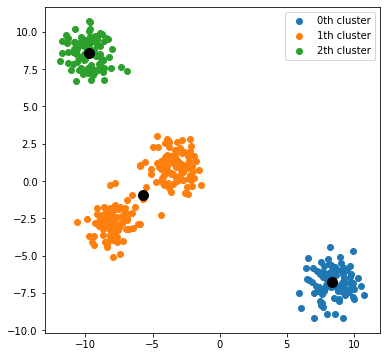

In [34]:
# choose number of clusters
k = 3 

# instantiate k-means clusterer
kmeans = KMeans(n_clusters = k)

# train the cluster
kmeans.fit(X)

# get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# plot clusters
plt.figure(figsize=(6,6))
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()

**Example 2:** when $k$ is too large, some clusters get chopped into multiple pieces

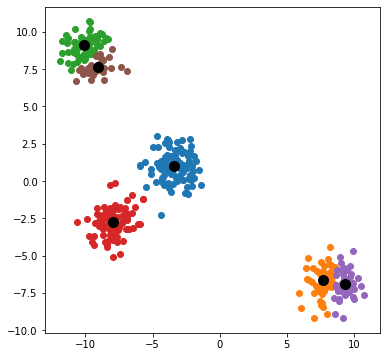

In [35]:
# choose number of clusters
k = 6 

# instantiate k-means clusterer
kmeans = KMeans(n_clusters = k)

# train the cluster
kmeans.fit(X)

# get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# plot clusters
plt.figure(figsize=(6,6))
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
#plt.legend()

### Inertia

One way to choose the number of clusters is to run the $k$-means algorithm multiple times with different values for $k$, and plot the inertia as a function of $k$. 
The inertia curve often contains an inflexion point called **the elbow**.

Text(0, 0.5, 'inertia')

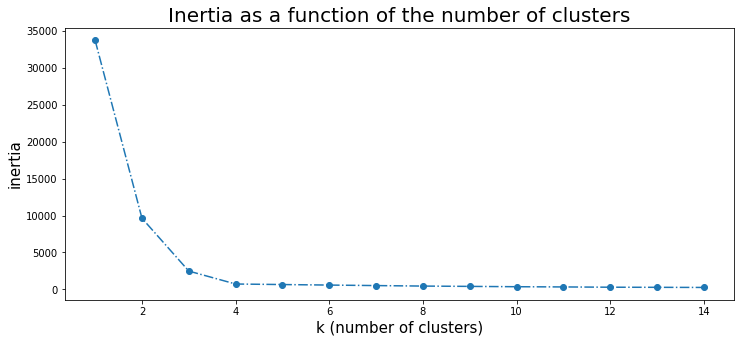

In [36]:
k_list = np.arange(1,15)
inertias = []
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
plt.figure(figsize=(12,5))
plt.plot(k_list,inertias,'o-.')
plt.title('Inertia as a function of the number of clusters',fontsize=20)
plt.xlabel('k (number of clusters)', fontsize=15)
plt.ylabel('inertia', fontsize=15)

### Silhouette score

An alternatice approach is to use the silhouette score

Text(0, 0.5, 'silhouette score')

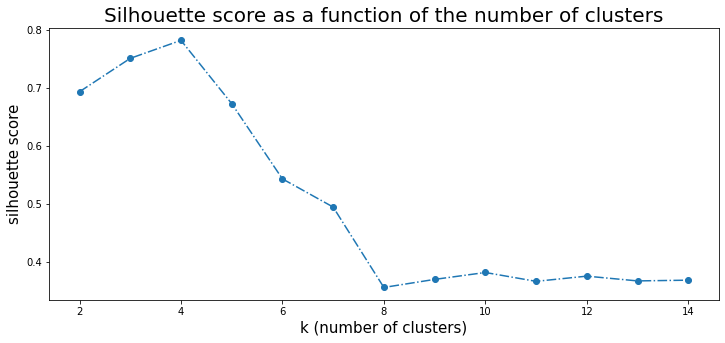

In [37]:
k_list = np.arange(2,15)
scores = []
for k in k_list:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scores.append(silhouette_score(X,kmeans.labels_))
    
plt.figure(figsize=(12,5))
plt.plot(k_list,scores,'o-.')
plt.title('Silhouette score as a function of the number of clusters',fontsize=20)
plt.xlabel('k (number of clusters)', fontsize=15)
plt.ylabel('silhouette score', fontsize=15)

The silhouette score confirms that $k=4$ is a good choice.

### Silhouette diagram

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a silhouette diagram

In [60]:
kmeans = KMeans(n_clusters = 5)

# train the cluster
kmeans.fit(X)

KMeans(n_clusters=5)

In [61]:
def plot_silhouette_diagram(model,X):
    from sklearn.metrics import silhouette_samples
    from matplotlib.ticker import FixedLocator, FixedFormatter
    from matplotlib import cm
    
    # get cluster labels, cluster centers, number of clusters, and silhouete scores
    labels = model.labels_
    centers = model.cluster_centers_
    k = len(np.unique(labels))
    silhouette_coefficients = silhouette_samples(X,labels)
    
    # plot silhouette diagrams
    plt.figure(figsize=(15,10))
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[labels == i]
        coeffs.sort()
        color = cm.Spectral(i/k)
        plt.fill_betweenx(np.arange(pos,pos+len(coeffs)),0,coeffs,facecolor=color,edgecolor=color,alpha=0.7)
        
        ticks.append(pos + len(coeffs)//2)
        pos += len(coeffs) + padding
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    
    plt.axvline(x=silhouette_score(X,labels),color='red',linestyle='--')

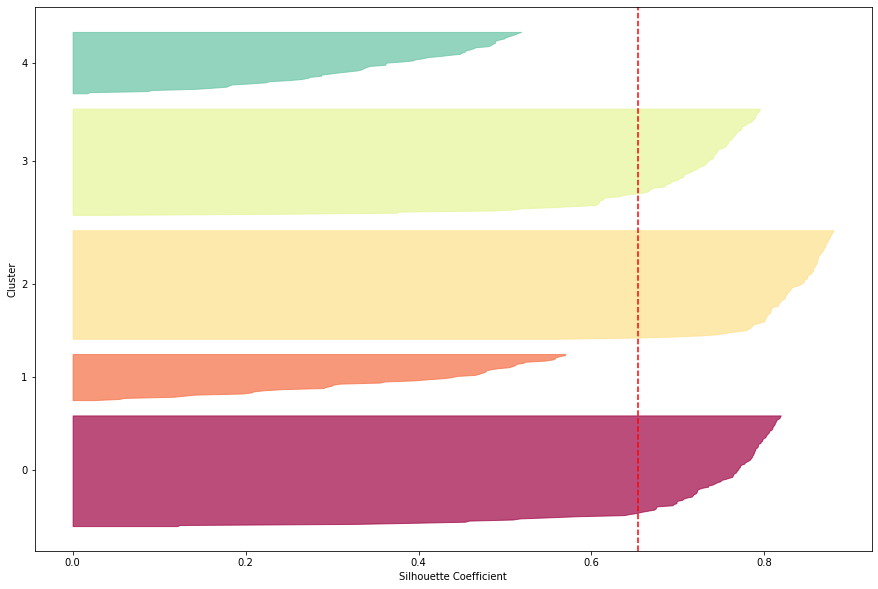

In [62]:
plot_silhouette_diagram(kmeans,X)

## 5. Demonstration of k-means assumptions

The k-means algorithm makes the assumption that clusters are [**convex**](https://en.wikipedia.org/wiki/Convex_set) and [**isotropic**](https://en.wikipedia.org/wiki/Isotropy), which is not always the case. It responds poorly to elongated clusters, or clusters with irregular shapes.

The following examples show situations where the $k$-means algorithm produces unintuitive and possibly unexpected clusters.

**Example 1:** Anisotropicly distributed data (i.e., elongated clusters)

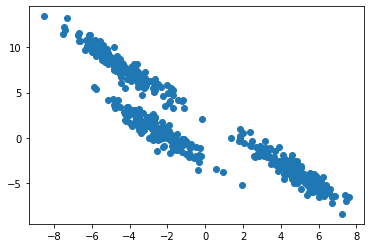

In [64]:
# three-elongated-blobs dataset
transformation = np.array([[0.6, -0.6], [-0.4, 0.8]])

#X[0:100] = np.random.randn(100,2) + [-2,2]
#X[100:200] = np.random.randn(100,2) + [5,7]
#X[200:300] = np.random.randn(100,2) + [-5,-7]

X,y = make_blobs(n_samples=500,centers=3,cluster_std=2)

X = X.dot(transformation)
plt.scatter(X[:,0],X[:,1])

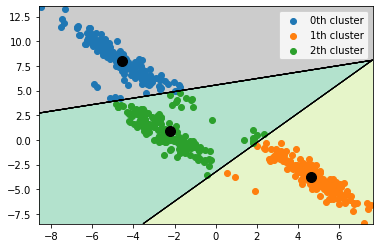

In [65]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Voronoi diagrams
plot_decision_regions(kmeans,X)
# plot clusters
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()


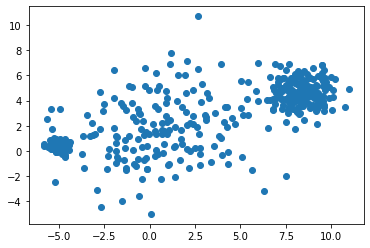

In [70]:
# unequal variance
X,y = make_blobs(n_samples=500,centers=3,cluster_std=[2.5,1,0.25])
plt.scatter(X[:,0],X[:,1])

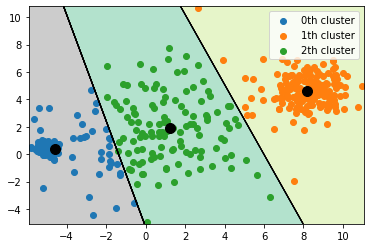

In [71]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Voronoi diagrams
plot_decision_regions(kmeans,X)
# plot clusters
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()


**Example 2:** Clusters with irregular shapes.

**Moons dataset**

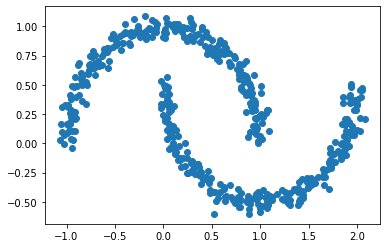

In [154]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=500,noise=0.05)
plt.plot(X[:,0],X[:,1],'o')

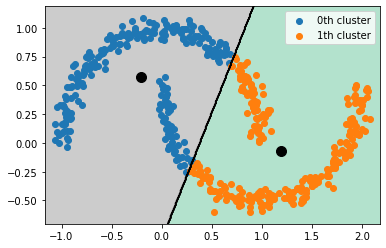

In [155]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Voronoi diagrams
plot_decision_regions(kmeans,X)

# plot clusters
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()

**Circles dataset**

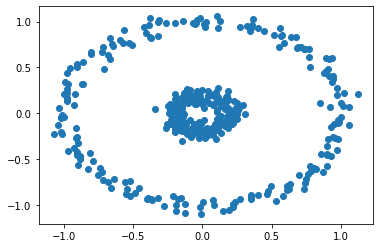

In [156]:
from sklearn.datasets import make_circles
X,y = make_circles(n_samples=400,noise=0.05, factor=0.2)
plt.plot(X[:,0],X[:,1],'o')

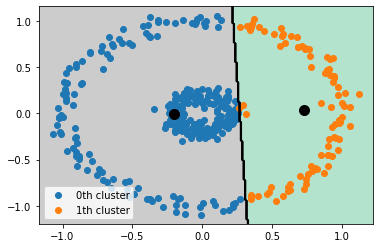

In [157]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Voronoi diagrams
plot_decision_regions(kmeans,X)

# plot clusters
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()

**Example 3:** Unevenly sized clusters

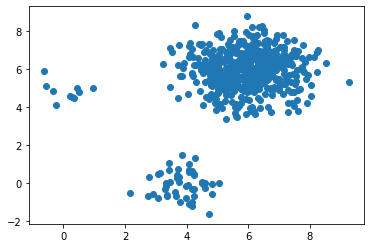

In [158]:
X = np.zeros((560,2)) 
X[0:500] = np.random.randn(500,2) + [6,6] # blob 1 (big)
X[500:550] = 0.7*np.random.randn(50,2) + [4,0] # blob 2 (medium)
X[550:560] = 0.5*np.random.randn(10,2) + [0,5] # blob 3 (small)

plt.plot(X[:,0],X[:,1],'o')

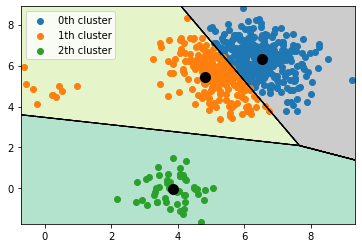

In [159]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Voronoi diagrams
plot_decision_regions(kmeans,X)

# plot clusters
for i in range(k):
    # plot ith cluster
    plt.scatter(X[labels==i,0],X[labels==i,1], label=str(i)+'th cluster')
    plt.scatter(centers[i,0],centers[i,1], c='k', s=100)
plt.legend()

## Appendix: code to generate Section 2 figure

In [39]:
X = np.zeros((400,2)) #2 features; 400 data points
X[0:100] =   1.75*np.random.randn(100,2) + [-5,5] # blob 1
X[100:200] = 1.75*np.random.randn(100,2) + [4,-5] # blob 2
X[200:300] = 1.75*np.random.randn(100,2) + [6,6] # blob 3
X[300:400] = 1.75*np.random.randn(100,2) + [-5,-6]

In [83]:
random_state=3
kmeans_iter1=KMeans(n_clusters=4, init="random", n_init=1,algorithm="full", max_iter=1, random_state=random_state)
kmeans_iter2=KMeans(n_clusters=4, init="random", n_init=1,algorithm="full", max_iter=2, random_state=random_state)
kmeans_iter3=KMeans(n_clusters=4, init="random", n_init=1,algorithm="full", max_iter=3, random_state=random_state)
kmeans_iter4=KMeans(n_clusters=4, init="random", n_init=1,algorithm="full", max_iter=4, random_state=random_state)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)
kmeans_iter4.fit(X)

KMeans(algorithm='full', init='random', max_iter=4, n_clusters=4, n_init=1,
       random_state=3)

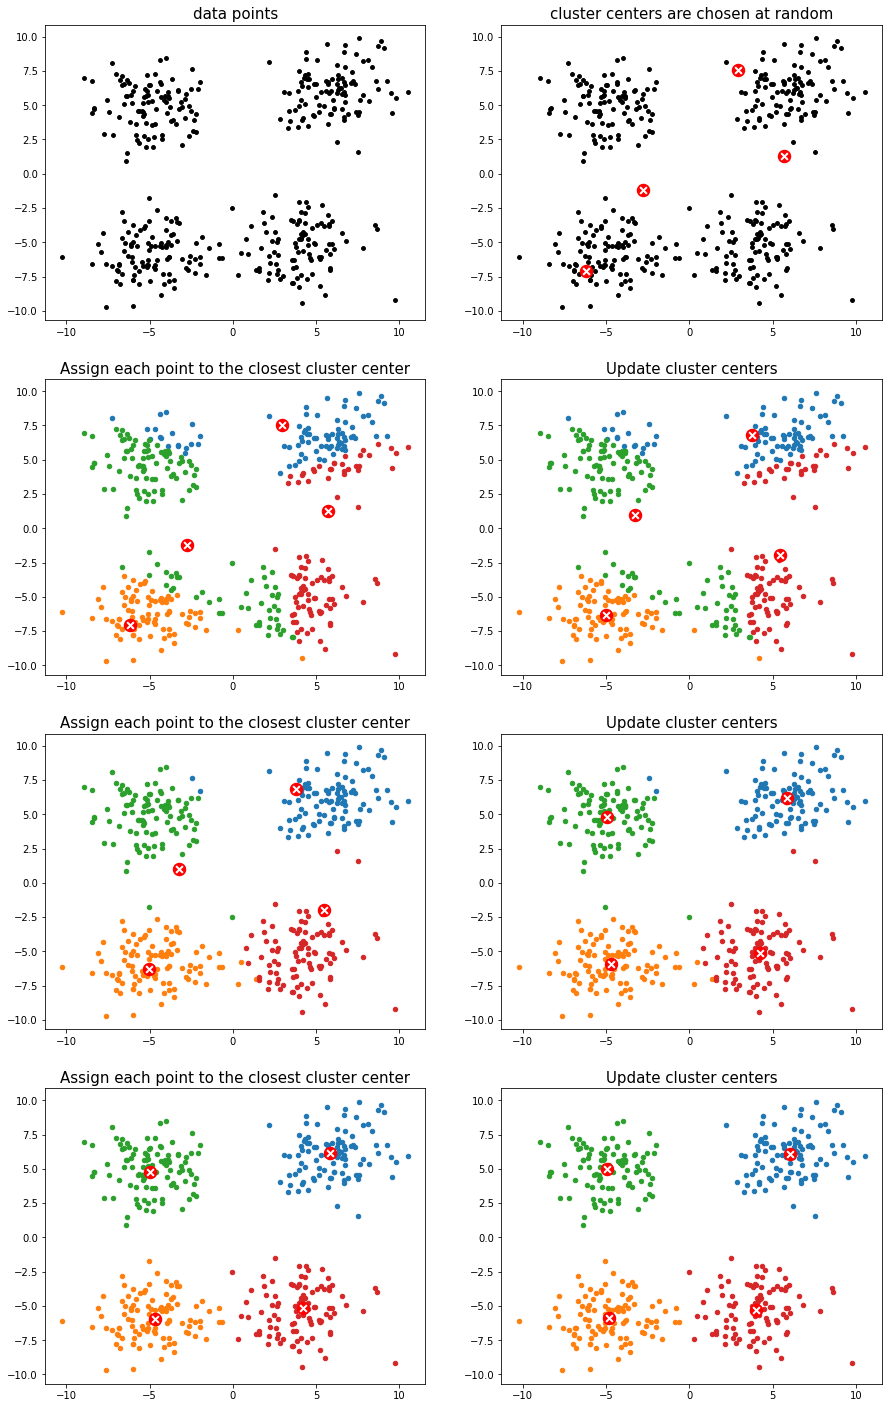

In [85]:
fig, ax = plt.subplots(4,2, figsize=(15,25))

# data
ax[0,0].scatter(X[:,0],X[:,1],c='k',s=15)
ax[0,0].set_title('data points', fontsize=15)

# initialization
centers = kmeans_iter1.cluster_centers_
ax[0,1].scatter(X[:,0],X[:,1],c='k',s=15)
ax[0,1].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[0,1].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[0,1].set_title('cluster centers are chosen at random', fontsize=15)

# iteration 1: label the points
labels = kmeans_iter1.labels_
for i in range(4):
    ax[1,0].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[1,0].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[1,0].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[1,0].set_title('Assign each point to the closest cluster center',fontsize=15)

# iteration 1: update cluster centers
centers = kmeans_iter2.cluster_centers_
for i in range(4):
    ax[1,1].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[1,1].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[1,1].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[1,1].set_title('Update cluster centers',fontsize=15)

# iteration 2: label the points
labels = kmeans_iter2.labels_
for i in range(4):
    ax[2,0].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[2,0].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[2,0].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[2,0].set_title('Assign each point to the closest cluster center',fontsize=15)

# iteration 2: update cluster centers
centers = kmeans_iter3.cluster_centers_
for i in range(4):
    ax[2,1].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[2,1].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[2,1].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[2,1].set_title('Update cluster centers',fontsize=15)

# iteration 3: label the points
labels = kmeans_iter3.labels_
for i in range(4):
    ax[3,0].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[3,0].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[3,0].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[3,0].set_title('Assign each point to the closest cluster center',fontsize=15)

# iteration 3: update cluster centers
centers = kmeans_iter4.cluster_centers_
for i in range(4):
    ax[3,1].scatter(X[labels==i,0],X[labels==i,1],s=20)
ax[3,1].scatter(centers[:,0],centers[:,1],marker='o',s=30,linewidths=8,color='r',zorder=10)
ax[3,1].scatter(centers[:,0],centers[:,1],marker='x',s=45,linewidths=2,color='w',zorder=11)
ax[3,1].set_title('Update cluster centers',fontsize=15)
plt.savefig('kmeans.png')